In [7]:
import numpy as np
import torch
import matplotlib.pylab as pl
import pylab
import math
import ot
import proplot as plot
plot.rc['figure.facecolor'] = "white"

In [8]:
if torch.cuda.is_available():
    device='cuda'
    dtype = torch.cuda.DoubleTensor
else:
    device='cpu'
    dtype=torch.DoubleTensor
print(device)

device='cpu'
dtype=torch.DoubleTensor
torch.set_default_tensor_type(dtype)

cuda


In [9]:
import sys
sys.path.append('../code/')

In [10]:
from generate_data import make_data
from SWGG import SWGG_CP
from utils import random_slice

In [11]:
n_seed=50

n_dim=20
max_dim=2.5#10^
dim_l = np.logspace(.5, max_dim, n_dim, dtype=int)
print('dim',dim_l)

n=50
res=torch.empty((n_seed,len(dim_l)))
for i in range(n_seed):
    print(i,end=' ')
    for j,d in enumerate(dim_l):
        theta=random_slice(100,d).T.float()
        X,Y=make_data('gaussians',n,d)
        ns=X.shape[0]
        
        C=ot.dist(X,Y)
        a, b = torch.ones((ns,))/ns, torch.ones((ns,))/ns
        W=ot.emd2(a,b,C,numItermax=1000000)
        
        res[i,j]=torch.min(SWGG_CP(X,Y,theta)[0])/W
res_mean=torch.mean(res,axis=0)
res_std=torch.std(res,axis=0)
label=['Exact Wasserstein','SWGG']

dim [  3   4   5   6   8  10  13  17  21  28  35  45  57  73  94 119 152 194
 248 316]
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

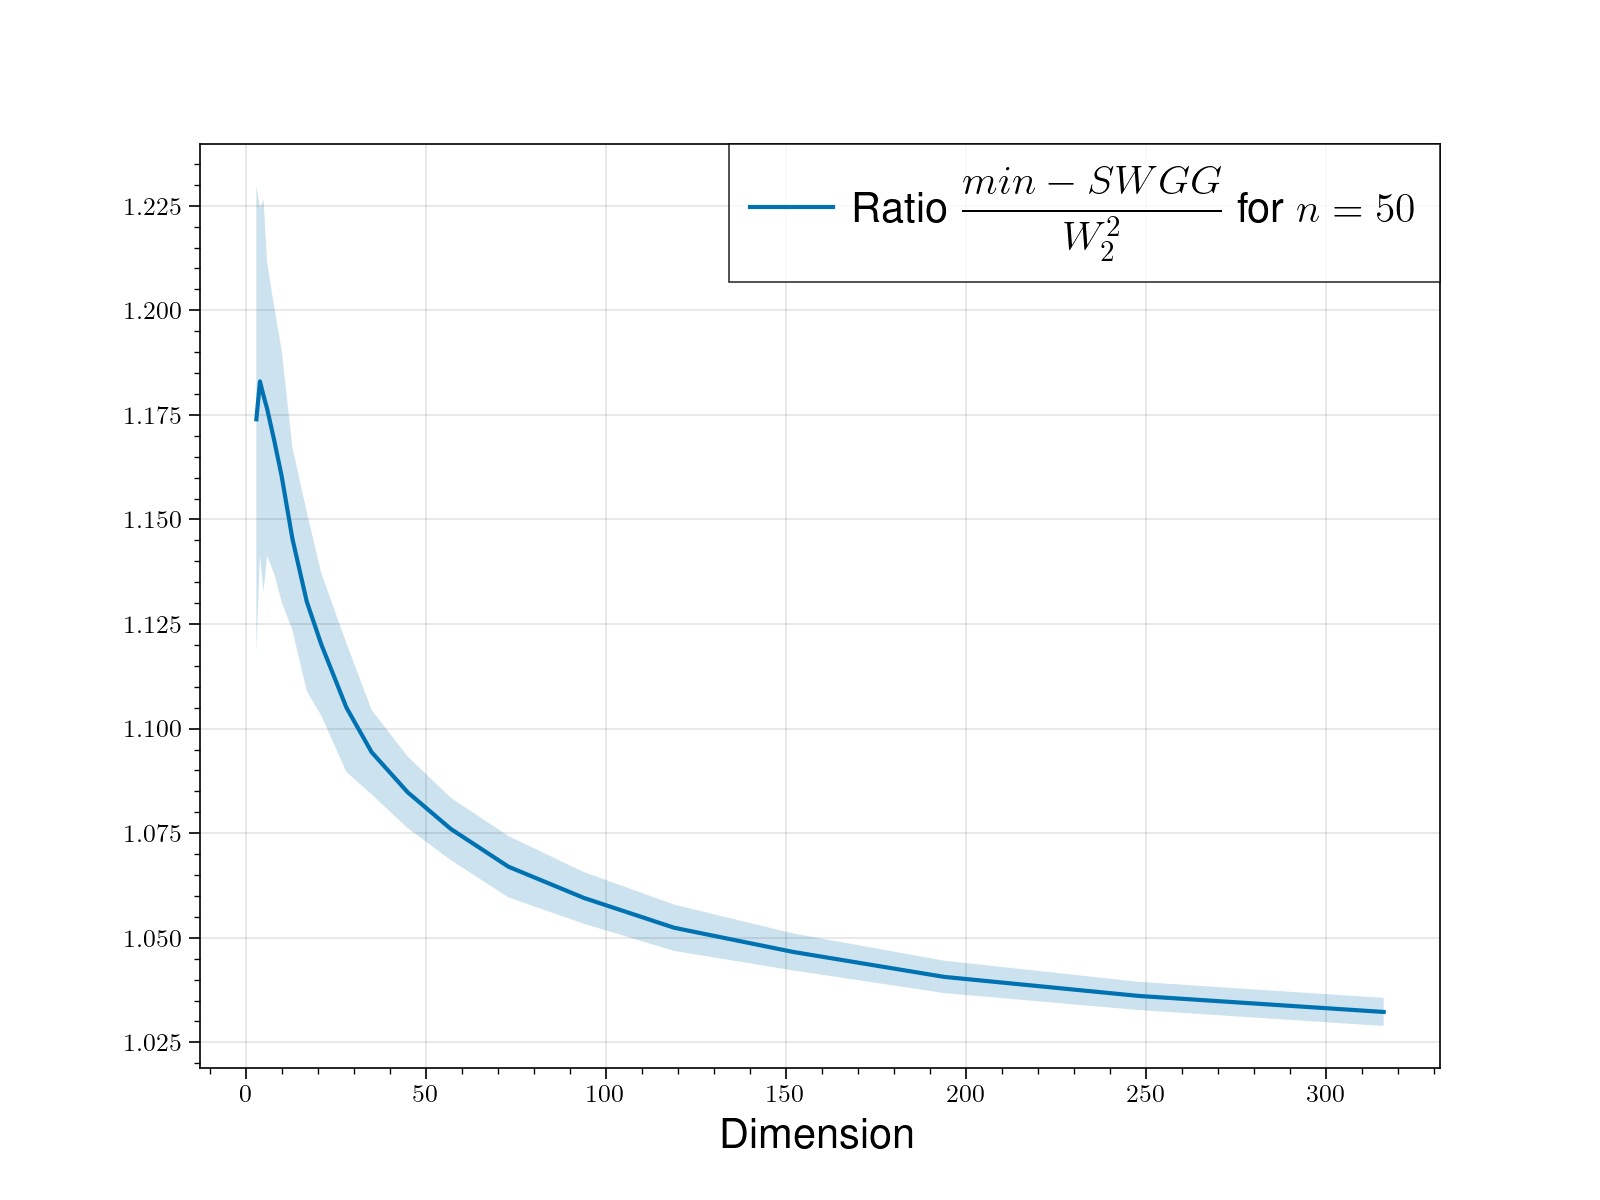

In [12]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
fig, ax = pl.subplots(figsize=(8, 6))
pl.plot(dim_l, res_mean,c='C0',label=r'Ratio $\displaystyle\frac{min-SWGG}{W^2_2}$ for $n=50$')
pl.fill_between(dim_l, res_mean -  2*res_std, res_mean + 2*res_std, alpha=0.2,label="")
pl.xlabel("Dimension",fontsize=15)
pl.legend(prop={'size': 15})
pl.savefig("behavior_d_1.pdf")
pl.show()

In [13]:
def make_Q(n,d):
    n=n-1
    Q=[n*[2]]
    for j in range(1,d):
        for i in range(0,n):
            if i==0:
                Q=Q+[[2]]
            else:
                Q[j].append(Q[j][i-1]+(i+1)*Q[j-1][i-1])
                
    Q_l=[]
    for l in range(len(Q)):
        Q_l.append(math.log(Q[l][-1]))
    return Q_l
n=310
dim=300
dim_l=torch.arange(1,dim+1)
F=math.log(math.factorial(n))
Q=make_Q(n,dim)

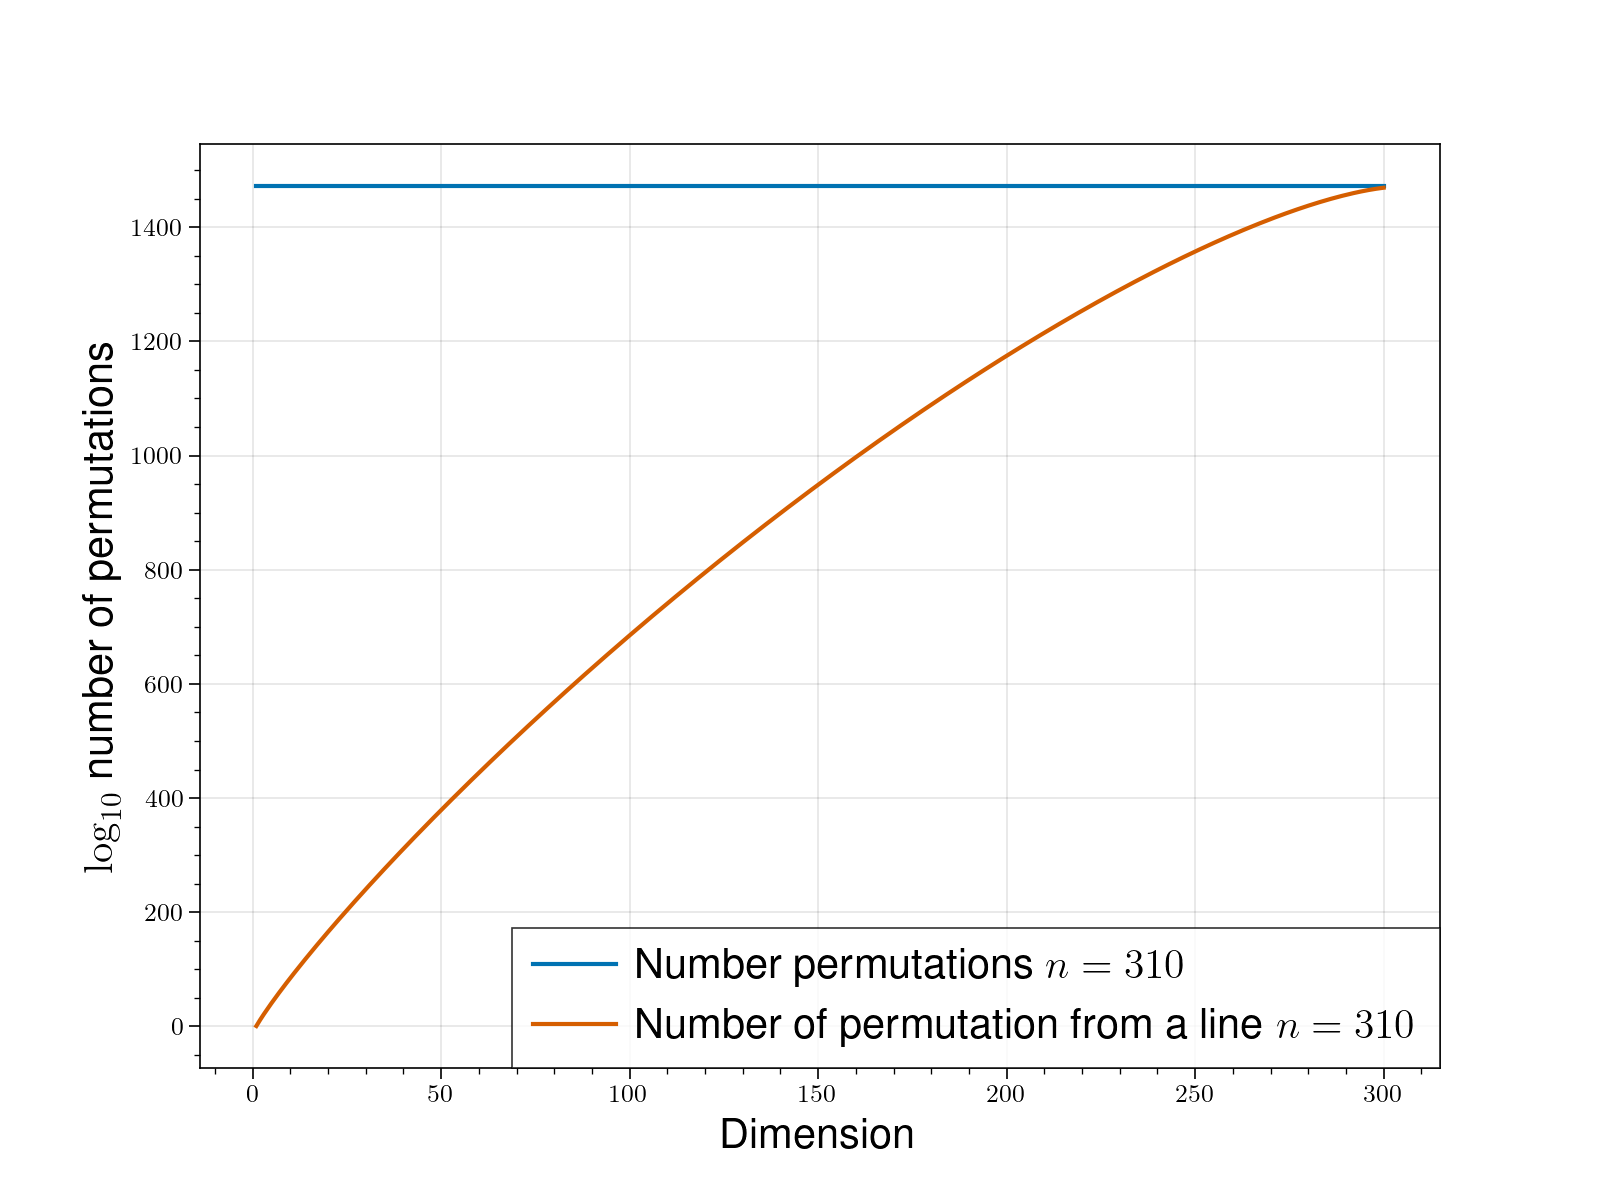

In [14]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

pl.figure(figsize=(8,6))
pl.plot(dim_l, F*torch.ones(dim_l.shape),c='C0',label='Number permutations $n = 310$')
pl.plot(dim_l, Q,c='C1',label='Number of permutation from a line $n = 310$')
pl.xlabel("Dimension",fontsize=15)
pl.ylabel("$\log_{10}$ number of permutations",fontsize=15)
pl.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
pl.rcParams['axes.titlepad'] = -30  # pad is in points...
pl.legend(prop={'size': 15})
pl.savefig("behavior_d_2.pdf")
pl.show()

In [15]:
n_seed=10


n_l=np.power(2,np.arange(1,13),dtype=int)
print('nb point',n_l)

dim=4
res=torch.empty((n_seed,len(n_l),2))
for i in range(n_seed):
    print(i,end=' ')
    theta=random_slice(1000,dim).T.float()
    for j,n in enumerate(n_l):
        X,Y=make_data('gaussians',n,dim)
        ns=X.shape[0]
        
        C=ot.dist(X,Y)
        a, b = torch.ones((ns,))/ns, torch.ones((ns,))/ns
        res[i,j,0]=ot.emd2(a,b,C,numItermax=1000000)
        
        res[i,j,1]=torch.min(SWGG_CP(X,Y,theta)[0])    
res_mean=torch.mean(res,axis=0)
res_std=torch.std(res,axis=0)



nb point [   2    4    8   16   32   64  128  256  512 1024 2048 4096]
0 1 2 3 4 5 6 7 8 9 

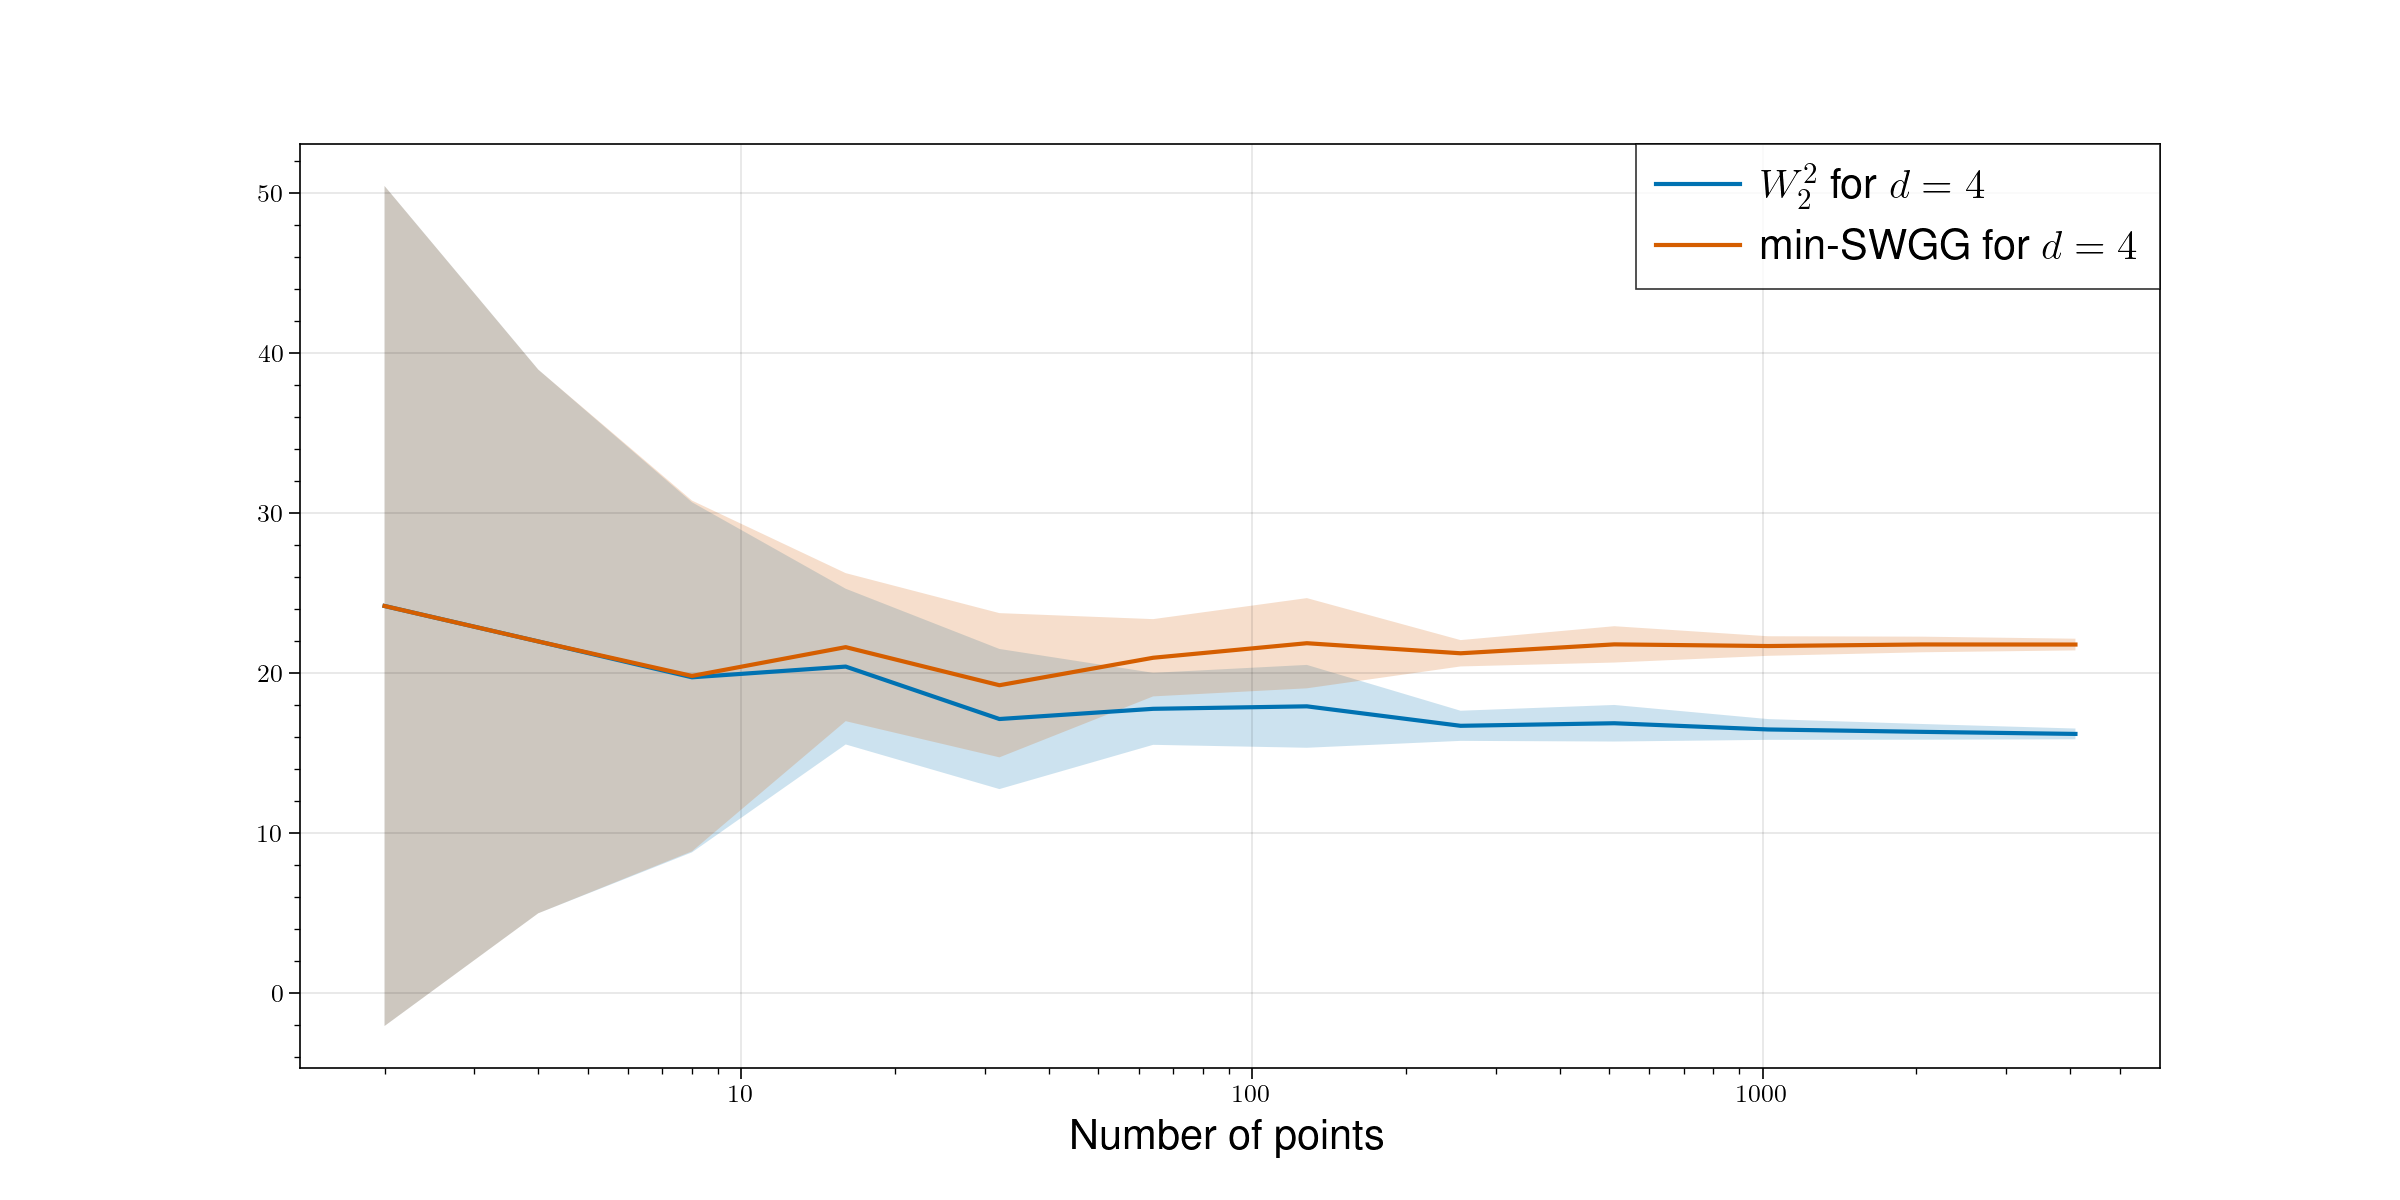

In [16]:
label=['$W_2^2$ for $d=4$','min-SWGG for $d=4$']
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

pl.figure(figsize=(12,6))
for i in range(len(label)):
    pl.plot(n_l, res_mean[:,i],c='C%i'%i,label=label[i])
    pl.fill_between(n_l, res_mean[:,i] -  2*res_std[:,i], res_mean[:,i] + 2*res_std[:,i], alpha=0.2)
pl.xscale('log')
pl.xlabel("Number of points",fontsize=15)
pl.ylabel("")
pl.legend(prop={'size': 15})
pl.savefig("behavior_n.pdf")
pl.show()